In [2]:
import numpy as np
from scipy.spatial import KDTree
import matplotlib.pyplot as plt

## KDTree

In [3]:
# Example cell centers and dimensions
centers = np.random.rand(249, 2)  # Random centers for illustration
widths = np.random.rand(249)  # Random widths
heights = np.random.rand(249)  # Random heights

# Build a KDTree for spatial indexing
tree = KDTree(centers)

# Function to check if a point is within a cell
def is_point_in_cell(point, center, width, height):
    # Simple bounding box check
    return (np.abs(point[0] - center[0]) <= width / 2) and (np.abs(point[1] - center[1]) <= height / 2)



def vectorized_boundary_check(points, centers, widths, heights):
    # Calculate the differences between points and cell centers
    dx = np.abs(points[:, np.newaxis, 0] - centers[:, 0])
    dy = np.abs(points[:, np.newaxis, 1] - centers[:, 1])

    # Check if points are within the cell boundaries
    within_width = dx <= widths / 2
    within_height = dy <= heights / 2

    # Combine the conditions
    within_cells = np.logical_and(within_width, within_height)

    return within_cells

In [4]:
# Example usage
point = np.array([0.5, 0.5])
distance, index = tree.query(point)
if is_point_in_cell(point, centers[index], widths[index], heights[index]):
    print(f"Point {point} is in cell {index}")
else:
    print(f"Point {point} is not in any cell")


Point [0.5 0.5] is in cell 94


In [5]:
points = np.random.rand(10, 249, 2)

In [6]:
_, cells = tree.query(points)

for i in range(points.shape[0]):
    within_cells = vectorized_boundary_check(points[i], centers[cells][i], widths, heights)
    print(within_cells.shape)
    

(249, 249)
(249, 249)
(249, 249)
(249, 249)
(249, 249)
(249, 249)
(249, 249)
(249, 249)
(249, 249)
(249, 249)


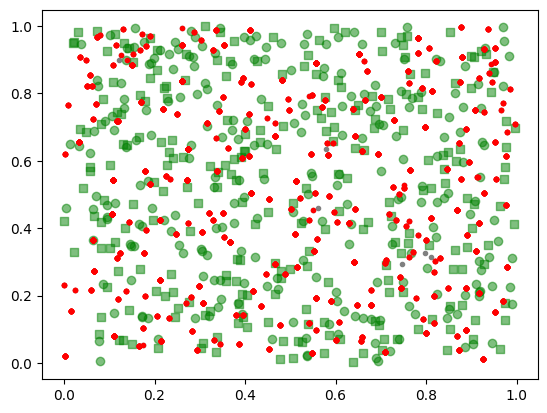

In [7]:
#_, cells = tree.query(points)
#print("points:", points)
#print(cells)
#print("centers:", centers[cells])

plt.scatter(points[0][:,0], points[0][:,1], color="green", marker="o", alpha=0.5, label="points 1")
plt.scatter(points[1][:,0], points[1][:,1], color="green", marker="s", alpha=0.5, label="points 2")
plt.scatter(centers[:,0], centers[:,1], color="grey", marker=".", label="centers")
plt.scatter(centers[cells].reshape(-1,2)[:,0], centers[cells].reshape(-1,2)[:,1], color="red", marker=".", label="centers")


#plt.legend()

In [63]:
centers[cells].reshape(-1,2)


array([[0.880627  , 0.4313659 ],
       [0.69439179, 0.97837452],
       [0.60573597, 0.94646373],
       [0.61969781, 0.1501423 ],
       [0.23850931, 0.66049779],
       [0.22903147, 0.65401978],
       [0.7351209 , 0.5510219 ],
       [0.47887851, 0.12280088],
       [0.32534665, 0.82397115],
       [0.43723512, 0.25808553]])

In [64]:
centers[cells]

array([[[0.880627  , 0.4313659 ],
        [0.69439179, 0.97837452],
        [0.60573597, 0.94646373],
        [0.61969781, 0.1501423 ],
        [0.23850931, 0.66049779]],

       [[0.22903147, 0.65401978],
        [0.7351209 , 0.5510219 ],
        [0.47887851, 0.12280088],
        [0.32534665, 0.82397115],
        [0.43723512, 0.25808553]]])

In [ ]:
_, cells = tree.query(points)
cells

## R-tree

In [107]:
# Create an R-tree index
idx = index.Index()

# Example cell boundaries (x_min, y_min, x_max, y_max)
cell_boundaries = [(i, i, i + 1, i + 1) for i in range(249)]

# Insert cell boundaries into the index
for i, bounds in enumerate(cell_boundaries):
    idx.insert(i, bounds)

# Example point to search for
point = (1.5, 1.5)

# Query the R-tree to find which cells intersect with the point
intersecting_cells = list(idx.intersection(point))

print(intersecting_cells)


[1]


In [111]:
idx.intersection(point)

<generator object Index._get_ids at 0x7754b9cace10>

# What do I want to do?

I want to use the `tree = KDTree(centers)` and `_, cells = tree.query(points)` to map points to a list of center coordinates.

I want to construct an adjacency matrix and a distance matrix.

The matrices will be constructed based on a list of centers and their widths.

Then I have a quick mapping between points and the cells.

The assumption is that the points will be very close to the centers.

For irregular cells it can't be used to map hits to digits without something extra (imagine a big cell next to a small cell, a point slightly inside the big cell will be closer to the center of the small cell).

In [8]:
import focal as foc
import importlib
importlib.reload(foc)

<module 'focal' from '/home/bjartur/workspace/notebooks/focalh_playground/focal.py'>

In [9]:
f = foc.FocalH()

In [10]:
def centroid(vertices):
    xmin = vertices[:,0].min()
    xmax = vertices[:,0].max()
    ymin = vertices[:,1].min()
    ymax = vertices[:,1].max()    
    return (xmax+xmin)/2, (ymax+ymin)/2

def width(vertices):
    xmin = vertices[:,0].min()
    xmax = vertices[:,0].max()
    return xmax-xmin

def height(vertices):
    ymin = vertices[:,1].min()
    ymax = vertices[:,1].max()
    return ymax-ymin


def search(x, y, paths):
    for i, path in enumerate(paths):
        if path.contains_point((x,y)):
            return i
    return -1

def neighborhood(cell, paths):
    neighbors = []
    e = 0.001
    w,h = e+width(paths[cell].vertices)/2, e+height(paths[cell].vertices)/2
    c = centroid(paths[cell].vertices)
    neighbors.append(search(c[0]+w,c[1],paths))
    neighbors.append(search(c[0]+w,c[1]+h,paths))
    neighbors.append(search(c[0],c[1]+h,paths))
    neighbors.append(search(c[0]-w,c[1]+h,paths))
    neighbors.append(search(c[0]-w,c[1],paths))
    neighbors.append(search(c[0]-w,c[1]-h,paths))
    neighbors.append(search(c[0],c[1]-h,paths))
    neighbors.append(search(c[0]+w,c[1]-h,paths))
    neighbors = set([n for n in neighbors if n != -1])
    return np.array(list(neighbors), dtype=np.int32)

centroid(f.paths[0].vertices)
search(2.5,0,f.paths)
width(f.paths[127].vertices)
height(f.paths[127].vertices)
neighborhood(0, f.paths)

array([1, 5, 6], dtype=int32)

In [11]:
f.paths[0]

Path(array([[-9.75,  8.45],
       [-9.75,  9.75],
       [-8.45,  9.75],
       [-8.45,  8.45],
       [-9.75,  8.45]]), array([ 1,  2,  2,  2, 79], dtype=uint8))

In [12]:
f.paths[0].vertices.mean(axis=0)

array([-9.23,  8.97])

In [13]:
import focal as foc
import importlib
importlib.reload(foc)

def prototype2_plot_cells():
    f = foc.FocalH()
    fig, ax = plt.subplots(figsize=(8,8))
    for i,p in enumerate(f.paths):
        ax.plot(f.paths[i].vertices[:,0], f.paths[i].vertices[:,1])
        c = centroid(f.paths[i].vertices)
        #ax.scatter(c[0], c[1], s=5, color="grey", alpha=0.5)
        ax.text(c[0],c[1],str(i),fontsize=8,horizontalalignment='center',verticalalignment='center')
    ax.set_aspect("equal")
    ax.set_xlabel("x [cm]")
    ax.set_title("Virtual channel mapping")
    ax.set_xlim(-f.detector_width/2, f.detector_width/2)
    ax.set_ylim(-f.detector_height/2, f.detector_height/2)
    fig.savefig("channels.png", bbox_inches="tight")

def plot_neighborhood(cell):
    f = foc.FocalH()
    fig, ax = plt.subplots(figsize=(8,8))
    for i,p in enumerate(f.paths):
        ax.plot(f.paths[i].vertices[:,0], f.paths[i].vertices[:,1], color="grey", alpha=0.5)
        c = centroid(f.paths[i].vertices)
        ax.text(c[0],c[1],str(i),fontsize=8,horizontalalignment='center',verticalalignment='center', alpha=0.5)
        
    neighbors = neighborhood(cell, f.paths)
    
    for i in neighbors:
        ax.plot(f.paths[i].vertices[:,0], f.paths[i].vertices[:,1], color="orange")
        c = centroid(f.paths[i].vertices)
        #ax.scatter(c[0], c[1], s=5, color="grey", alpha=0.5)
        ax.text(c[0],c[1],str(i),fontsize=8,horizontalalignment='center',verticalalignment='center', color="orange")
    
    ax.plot(f.paths[cell].vertices[:,0], f.paths[cell].vertices[:,1], color="green")
    c = centroid(f.paths[cell].vertices)
    #ax.scatter(c[0], c[1], s=5, color="grey", alpha=0.5)
    ax.text(c[0],c[1],str(cell),fontsize=8,horizontalalignment='center',verticalalignment='center', color="green")

    
    ax.set_aspect("equal")
    ax.set_xlabel("x [cm]")
    ax.set_title("Virtual channel mapping")
    ax.set_xlim(-f.detector_width/2, f.detector_width/2)
    ax.set_ylim(-f.detector_height/2, f.detector_height/2)
    fig.savefig(str(cell)+"_neighbors.png", bbox_inches="tight")

def adjacency_matrix():
    f = foc.FocalH()
    A = np.zeros(249*249).reshape(249,249)
    index = np.linspace(0,248,249)
    for i in range(249):
        A[i][i] = 1
        n = neighborhood(i, f.paths)
        
        mask = np.isin(index,n)
        A[i][mask] = 1

    return A
            

Adj = adjacency_matrix()

In [14]:
f = foc.FocalH()
sum = 0
for i in range(Adj.shape[0]):
    n_adj = np.sort(np.where(Adj[i] == 1))
    n_fn = neighborhood(i, f.paths)
    n_fn = np.sort(np.append(n_fn, i))
    diff = n_adj-n_fn
    sum += diff.sum()
print(sum)

0


In [156]:
points = np.zeros(len(f.paths)*2).reshape(249,2)
